### Import modules

In [141]:
import networkx as nx
import graph_bandit_RL
from graph_bandit_helper_tools import *
import numpy as np
from known_rewards_helper_functions import get_Q_table
from tqdm import trange

%load_ext autoreload
%autoreload 2

SEED = 181731

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Our algorithm

In [142]:
def visit_all_nodes(gb):
    while True:
        unvisited = [i for i in range(n_nodes) if gb.visits[i]==0]

        if len(unvisited)==0:
            break

        dest = unvisited[0]

        next_path = nx.shortest_path(gb.G,gb.state,dest)
        for s in next_path[1:]:
            gb.step(s)

def get_ucb(gb):
    ave_reward = [np.mean(gb.G.nodes[i]['r_hist']) for i in range(gb.num_nodes)] 

    nm = [gb.visits[i] for i in range(gb.num_nodes)]

    tm = np.sum(nm)

    ucb = ave_reward + np.sqrt(2*np.log(tm)/nm)
    
    return ucb

def get_ucb_Q_table(gb):
     
    ucb = get_ucb(gb)
    
    gap = np.sort(list(set(ucb)))[-1]-np.sort(list(set(ucb)))[-2]

    TG = nx.diameter(gb.G)*np.max(ucb)/gap

    Q,k, _ = get_Q_table(gb.G,ucb,TG)
    return Q

def train_doubling_agent(n_samples,T,G,means, stdevs,init_node):
    doubling_regrets = np.zeros((n_samples,T))
    for i in trange(n_samples):

        Doubling = graph_bandit_RL.GraphBandit(means[i], stdevs[i], G)

        ## Visit all nodes
        visit_all_nodes(Doubling)

        H0 = len(Doubling.visitedStates)

        # Start learning

        Doubling.state = init_node

        while len(Doubling.visitedStates)-H0<T:
            ucb = get_ucb(Doubling)
            # Compute Q table.
            Q = get_ucb_Q_table(Doubling)

            # Travel to the node with the highest UCB
            while ucb[Doubling.state] < np.max(ucb):
                next_s = np.argmax(Q[Doubling.state,:])
                Doubling.step(next_s)

            target_count = 0+Doubling.G.nodes[Doubling.state]['n_visits']
            # Keep sampling the best UCB node until its number of samples doubles
            for _ in range(target_count):
                Doubling.step(Doubling.state)

        doubling_regrets[i,:]= Doubling.expectedRegret()[:T]

    return doubling_regrets


### Define parameters

Define the following parameters:  
$\texttt{T}:$ game length  
$\texttt{n_samples}:$ number of games to run   
$\texttt{episodes}:$ number of episodes; Let this be 1 for now 
$\texttt{n_nodes}:$ number of nodes in graph. 
$\texttt{mu_size}:$ the node means are drawn as $\mu\sim \texttt{mu_size}\times \mathcal{N}(0,1)$   
$\texttt{sigma_size}:$ the node standard deviations are set to $\texttt{sigma_size}$ 
$\texttt{epsilon}:$ exploration parameter (only applicable for Q-learning algorithms)  
$\texttt{epsilon_discount}:$ exploration discount parameter (only applicable for Q-learning algorithms)  
$\texttt{algorithms}:$ the algorithms to run. 


 



In [143]:
T = 1000
n_samples = 100
episodes = 1
n_nodes = 10
mu_size = 1
sigma_size = 1

# For Q-learning
epsilon = 0.9
epsilon_discount=0.99

# Select algorithms to run
algorithms = ['greedy', 
              'thompson', 
              'UCB', 
              'Q_learning', 
              # 'Q_table_UCB', 
              # 'Q_table_Thompson'
             ]


init_node = 0

# Line graph

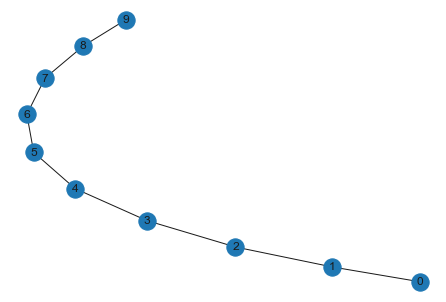

In [144]:
np.random.seed(SEED)
n_nodes = 10
G = return_graph('line', n_nodes)
draw_graph(G)

In [145]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=5.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

# Train benchmark agents
line_regrets, line_envs = testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=algorithms, G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {alg:init_node for alg in algorithms})

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


In [146]:
# Our Algorithm
line_regrets['Our Algorithm']=train_doubling_agent(n_samples,T,G,means, stdevs,init_node)

100%|██████████| 100/100 [00:02<00:00, 33.43it/s]


# Plot regrets

In [147]:
def plotRegrets(allRegrets, titles=None, save_fig=None):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    sns.set()
    colors = ['b', 'r', 'g', 'b', 'r', 'g','k']
    styles = ['solid', 'solid', 'solid', 'dotted', 'dotted', 'dotted','dotted']
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': 'Q-learning',\
              'Q_table_UCB': 'Q-graph with UCB',
              'Q_table_Thompson': 'Q-graph with TS', 
              'Q_table_hoeffding': 'Q_table_hoeffding',
             'random_path_UCB': 'Q-graph with UCB (arbitrary path)',
              'Our Algorithm':'Our Algorithm'}
    keys = allRegrets[0].keys()
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for i, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[i], linestyle = styles[i], label=labels[key],\
                    linewidth=3)
        if titles is not None:    
            plt.title(titles[0])
    else:
        fig, axes = plt.subplots(2, 3, figsize=(17,10))
        for j, regrets in enumerate(allRegrets):
            for i, key in enumerate(regrets.keys()):
                regret = regrets[key]
                regret = np.cumsum(regret, axis=1)
                df = pd.DataFrame(np.transpose(regret))
                df.columns = [labels[key] for _ in range(regret.shape[0])]
                if j<3:
                    sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[i]])
                    axes[0,j].set_title(titles[j])
                else:
                    sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[i]])
                    axes[1,j%3].set_title(titles[j])
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    plt.show()

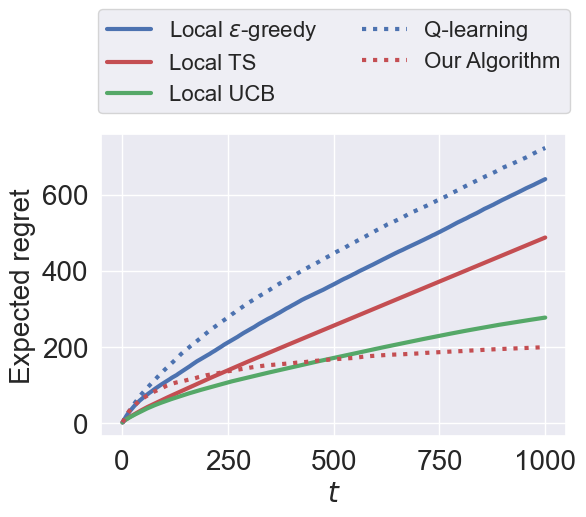

In [148]:
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=[''])

# Circle graph

np.random.seed(SEED)

G = return_graph('circle', n_nodes)
draw_graph(G)

In [149]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=5.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

# Train benchmark agents
circle_regrets, circle_envs = testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=algorithms, G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {alg:init_node for alg in algorithms})

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [150]:
# Our Algorithm
circle_regrets['Our Algorithm']=train_doubling_agent(n_samples,T,G,means, stdevs,init_node)

100%|██████████| 100/100 [00:03<00:00, 32.95it/s]


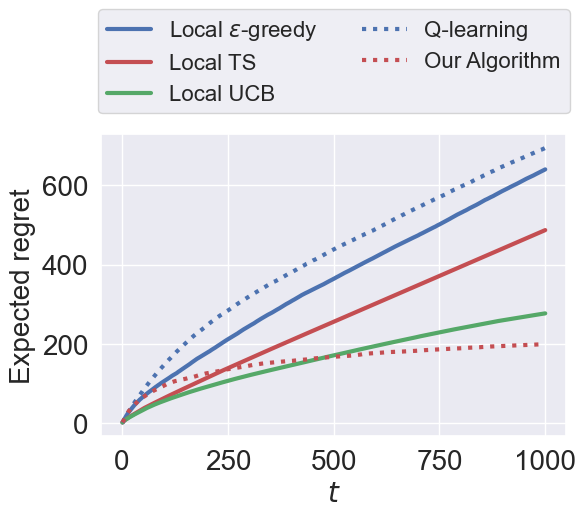

In [151]:
plt.figure(dpi=100)

plotRegrets([circle_regrets], titles=[''])

# Star graph

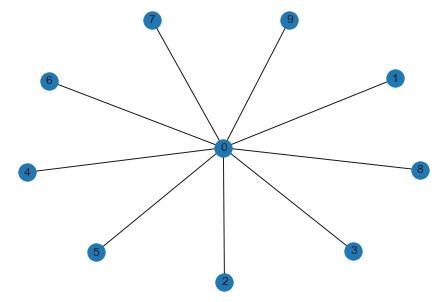

In [152]:
np.random.seed(SEED)
n_nodes = 10
G = return_graph('star', n_nodes)
draw_graph(G)

In [153]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=5.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

# Train benchmark agents
star_regrets, star_envs = testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=algorithms, G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {alg:init_node for alg in algorithms})

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [154]:
# Our Algorithm
star_regrets['Our Algorithm']=train_doubling_agent(n_samples,T,G,means, stdevs,init_node)

100%|██████████| 100/100 [00:03<00:00, 31.29it/s]


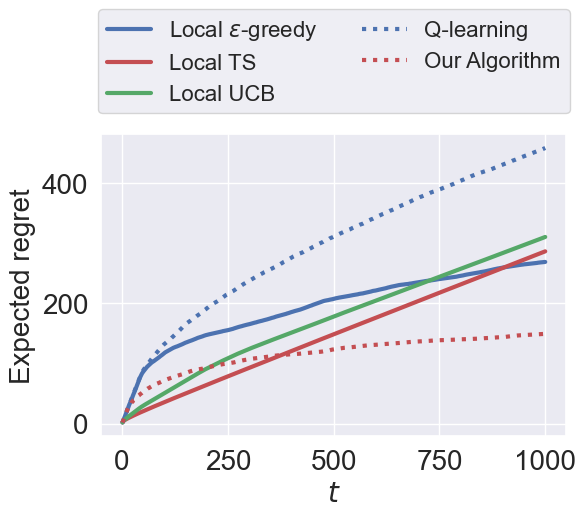

In [155]:
plt.figure(dpi=100)

plotRegrets([star_regrets], titles=[''])

# Tree graph

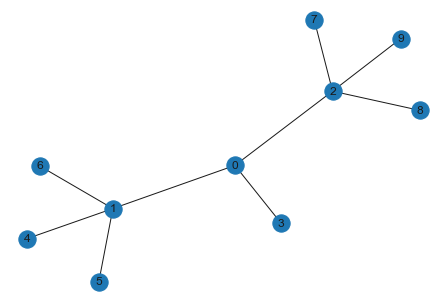

In [156]:
np.random.seed(SEED)
n_nodes = 10
G = return_graph('tree', n_nodes, n_children=3)
draw_graph(G)

In [157]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=5.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

# Train benchmark agents
tree_regrets, tree_envs = testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=algorithms, G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {alg:init_node for alg in algorithms})

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


In [158]:
# Our Algorithm
tree_regrets['Our Algorithm']=train_doubling_agent(n_samples,T,G,means, stdevs,init_node)

100%|██████████| 100/100 [00:03<00:00, 30.51it/s]


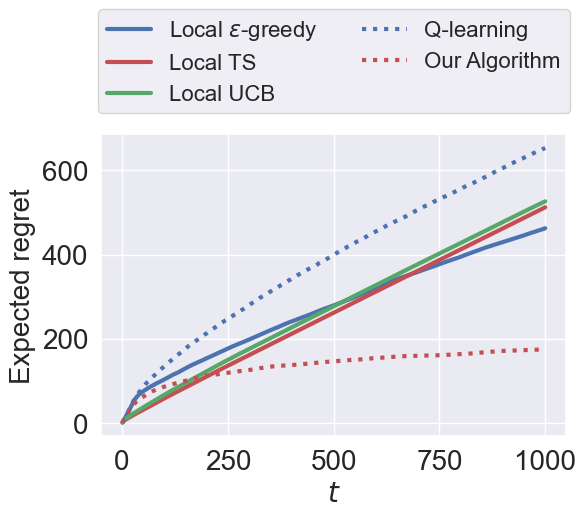

In [159]:
plt.figure(dpi=100)

plotRegrets([tree_regrets], titles=[''])

# Grid graph

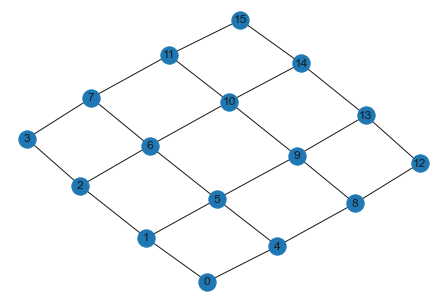

In [160]:
np.random.seed(SEED)
n_nodes=16

G = return_graph('maze', n_nodes)
draw_graph(G)

In [ ]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=5.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

# Train benchmark agents
grid_regrets, grid_envs = testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=algorithms, G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {alg:init_node for alg in algorithms})

 89%|████████▉ | 89/100 [01:33<00:11,  1.04s/it]

In [ ]:
# Our Algorithm
grid_regrets['Our Algorithm']=train_doubling_agent(n_samples,T,G,means, stdevs,init_node)

In [ ]:
plt.figure(dpi=100)

plotRegrets([grid_regrets], titles=[''])

# Fully connected graph

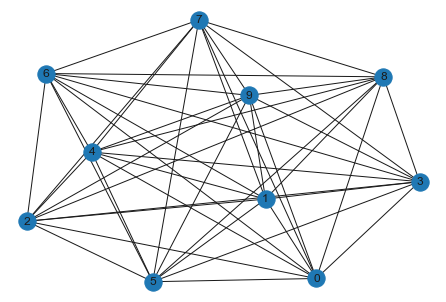

In [137]:
np.random.seed(SEED)
n_nodes = 10
G = return_graph('fully_connected', n_nodes)
draw_graph(G)

In [138]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=5.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

# Train benchmark agents
fully_connected_regrets, fully_connected_envs = testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=algorithms, G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {alg:init_node for alg in algorithms})

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [139]:
# Our Algorithm
fully_connected_regrets['Our Algorithm']=train_doubling_agent(n_samples,T,G,means, stdevs,init_node)

100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


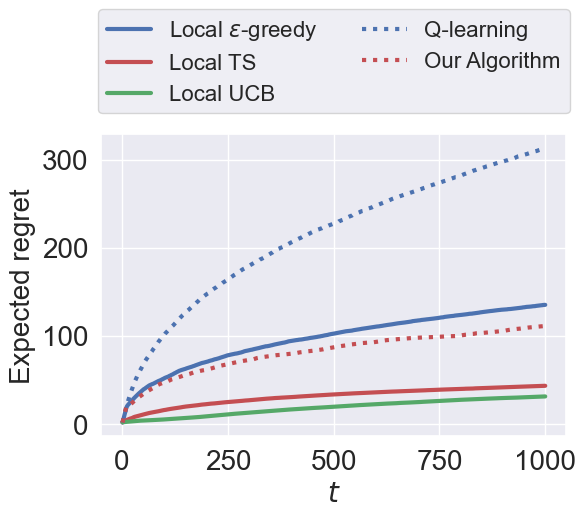

In [140]:
plt.figure(dpi=100)

plotRegrets([fully_connected_regrets], titles=[''])